# Experiment Results Analysis & Visualization

This notebook is for analyzing and plotting the results from the multi-treatment causal inference experiments. It contains three main sections:
1.  **Setup and Data Loading**: Imports libraries and parses all individual experiment runs from the `results` directory into a single pandas DataFrame.
2.  **Overall Performance Summary**: Generates a faceted plot comparing the Mean PEHE of all models across all scenarios and levels of treatment overlap (`kappa`).
3.  **Deep Dive into a Single Run**: Provides functions to generate detailed plots (True vs. Estimated CATE and CATE vs. Feature) for a single, specific experiment run of interest.

## 1. Setup and Data Loading

In [117]:
# Best plotting library
#!pip install tueplots

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tueplots import bundles, axes

from tueplots import cycler
from tueplots.constants import markers
from tueplots.constants.color import palettes
from tueplots.constants.color import rgb

plt.rcParams['text.usetex'] = False

# Increase the resolution of all the plots below
plt.rcParams.update({"figure.dpi": 300})

plt.rcParams.update(cycler.cycler(color=palettes.pn))

from tueplots import figsizes, fonts
plt.rcParams.update(figsizes.icml2022_full())
plt.rcParams.update(fonts.beamer_moml())

In [90]:
def parse_and_load_results(results_dir='results'):
    """
    Walks through the results directory, parses experiment parameters from
    directory names, and loads the PEHE results.
    """
    all_results = []
    
    if not os.path.exists(results_dir):
        print(f"Warning: Results directory '{results_dir}' not found.")
        return pd.DataFrame()
    
    for root, _, files in os.walk(results_dir):
        if 'cate_results.npz' in files:
            try:
                parts = root.replace('\\', '/').split('/')
                scenario, model = parts[-4], parts[-3]
                params = parts[-2].split('_')
                n_samples, kappa = int(params[0].replace('n', '')), float(params[1].replace('k', ''))
                seed = int(parts[-1].replace('seed', ''))
            except (IndexError, ValueError) as e:
                print(f"Could not parse directory name: {root}. Skipping.")
                continue

            result_data = np.load(os.path.join(root, 'cate_results.npz'))
            pehe_scores = result_data['pehe']
            
            all_results.append({
                'scenario': scenario, 'model': model, 'n_samples': n_samples,
                'kappa': kappa, 'seed': seed, 'pehe_t1_vs_t0': pehe_scores[0],
                'pehe_t2_vs_t0': pehe_scores[1], 'pehe_t3_vs_t0': pehe_scores[2]
            })

    if not all_results:
        print("No result files found. Please run the experiments first.")
        return pd.DataFrame()
        
    return pd.DataFrame(all_results)

# Load all the data
results_df = parse_and_load_results()
display(results_df.head())

Could not parse directory name: results/hyperparam_opt. Skipping.


,scenario,model,n_samples,kappa,seed,pehe_t1_vs_t0,pehe_t2_vs_t0,pehe_t3_vs_t0
0,education,causal_forest,2000,0.5,10,2.557117,2.131194,1.517139
1,education,causal_forest,2000,0.5,11,2.711279,2.081294,1.627898
2,education,causal_forest,2000,0.5,12,2.932803,1.938391,1.527871
3,education,causal_forest,2000,0.5,13,2.722684,2.329519,1.612595
4,education,causal_forest,2000,2.0,10,3.599040,3.457493,1.681457


In [23]:
results_df[results_df["seed"]==43]

,scenario,model,n_samples,kappa,seed,pehe_t1_vs_t0,pehe_t2_vs_t0,pehe_t3_vs_t0
160,education,hierarchical_mcfr,1000,0.5,43,0.881044,0.481244,0.458883
161,education,hierarchical_mcfr,1000,2.0,43,1.260738,0.894025,0.499080
162,education,hierarchical_mcfr,1000,5.0,43,1.283646,0.899389,0.487950
163,education,mcfrnet,1000,0.5,43,1.150408,0.413865,0.381040
164,education,mcfrnet,1000,2.0,43,1.451510,0.812766,0.529531
165,education,mcfrnet,1000,5.0,43,1.651674,0.792310,0.624828


In [35]:
results_df[(results_df["seed"]==1) & (results_df["n_samples"]==5000) & (results_df["scenario"]=="education")]

,scenario,model,n_samples,kappa,seed,pehe_t1_vs_t0,pehe_t2_vs_t0,pehe_t3_vs_t0
196,education,causal_forest,5000,0.5,1,2.236280,1.919254,1.516972
206,education,causal_forest,5000,2.0,1,3.153509,3.132698,1.903983
216,education,causal_forest,5000,5.0,1,3.824617,4.189673,2.342352
256,education,hierarchical_mcfr,5000,0.5,1,0.380322,0.352070,0.316294
266,education,hierarchical_mcfr,5000,2.0,1,0.524958,0.657014,0.322165
276,education,hierarchical_mcfr,5000,5.0,1,0.779484,0.997947,0.398286
316,education,mcfrnet,5000,0.5,1,0.403943,0.373623,0.190718
326,education,mcfrnet,5000,2.0,1,0.682888,0.958272,0.173276
336,education,mcfrnet,5000,5.0,1,0.821545,1.232041,0.193582
346,education,structured_mcfr,5000,0.5,1,4.706306,5.230052,4.388718


Quick comparison of the 4 models.

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tueplots import bundles

def plot_medication_summary(df):
    """
    Generates a focused plot for the medication scenario, forcing non-TeX rendering.
    """
    if df is None or df.empty:
        print("DataFrame is empty. No results to plot.")
        return
    
    pehe_cols = ['pehe_t1_vs_t0', 'pehe_t2_vs_t0', 'pehe_t3_vs_t0']
    df['pehe_avg'] = df[pehe_cols].mean(axis=1)

    model_order = ['structured_mcfr', 'mcfrnet', 'hierarchical_mcfr', 'causal_forest']
    
    # --- THE DEFINITIVE FIX IS HERE ---
    # 1. Get the base ICML style from the bundle
    icml_style = bundles.icml2022(family="sans-serif")
    
    # 2. Explicitly force the 'text.usetex' setting to False within the style itself.
    # This will override the bundle's default and any other conflicting settings.
    icml_style['text.usetex'] = False
    
    # 3. Apply the fully corrected style
    with plt.rc_context(icml_style):
        fig, ax = plt.subplots()
        
        sns.pointplot(
            data=df,
            x='kappa',
            y='pehe_avg',
            hue='model',
            hue_order=model_order,
            dodge=0.1, 
            errorbar=('ci', 95),
            capsize=.1,
            ax=ax
        )
        
        ax.set_xlabel('Overlap Parameter ($\\kappa$)')
        ax.set_ylabel('Mean PEHE')
        ax.set_title('Model Performance on Medication Scenario')
        ax.grid(True)
        ax.legend(title='Model')
        
        plt.tight_layout()
        plt.savefig('medication_summary_plot.pdf')
        print("Plot saved as 'medication_summary_plot.pdf'")
        plt.show()

In [97]:
#df_all_models_run = results_df[(results_df["seed"]==1) & (results_df["n_samples"]==5000) & (results_df["scenario"]=="education")]
df_all_models_run = results_df[results_df["seed"]==70]

In [92]:
df_all_models_run

,scenario,model,n_samples,kappa,seed,pehe_t1_vs_t0,pehe_t2_vs_t0,pehe_t3_vs_t0
238,education,causal_forest,1000,0.5,70,3.123477,2.693648,1.707507
239,education,causal_forest,1000,2.0,70,3.916045,4.375411,1.978118
240,education,causal_forest,1000,5.0,70,4.344825,4.509903,1.988953
241,education,hierarchical_mcfr,1000,0.5,70,0.826530,0.471459,0.406107
242,education,hierarchical_mcfr,1000,2.0,70,0.987274,1.000523,0.486891
243,education,hierarchical_mcfr,1000,5.0,70,1.255668,1.234180,0.515927
244,education,mcfrnet,1000,0.5,70,0.996007,0.479667,0.382845
245,education,mcfrnet,1000,2.0,70,1.161413,0.580805,0.460110
246,education,mcfrnet,1000,5.0,70,1.216388,1.139893,0.570722
247,education,structured_mcfr,1000,0.5,70,4.633549,4.973589,4.631194


/tmp/ipykernel_22532/444587925.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pehe_avg'] = df[pehe_cols].mean(axis=1)
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found 

Plot saved as 'medication_summary_plot.pdf'


RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmp0d13y7tv c9409456b61fdb51e17ab26a984ca0f5ef91678c8075b5f3b2332ddab93db748.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.24 (TeX Live 2022/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./c9409456b61fdb51e17ab26a984ca0f5ef91678c8075b5f3b2332ddab93db748.tex
LaTeX2e <2022-11-01> patch level 1
L3 programming layer <2023-01-16>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2022/07/02 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))

! LaTeX Error: File `type1cm.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.8 \usepackage
               {type1ec}^^M
No pages of output.
Transcript written on tmp0d13y7tv/c9409456b61fdb51e17ab26a984ca0f5ef91678c8075b
5f3b2332ddab93db748.log.




<Figure size 1650x1019.76 with 1 Axes>

findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the following families were found: Roboto Condensed
findfont: Generic family 'sans-serif' not found because none of the foll

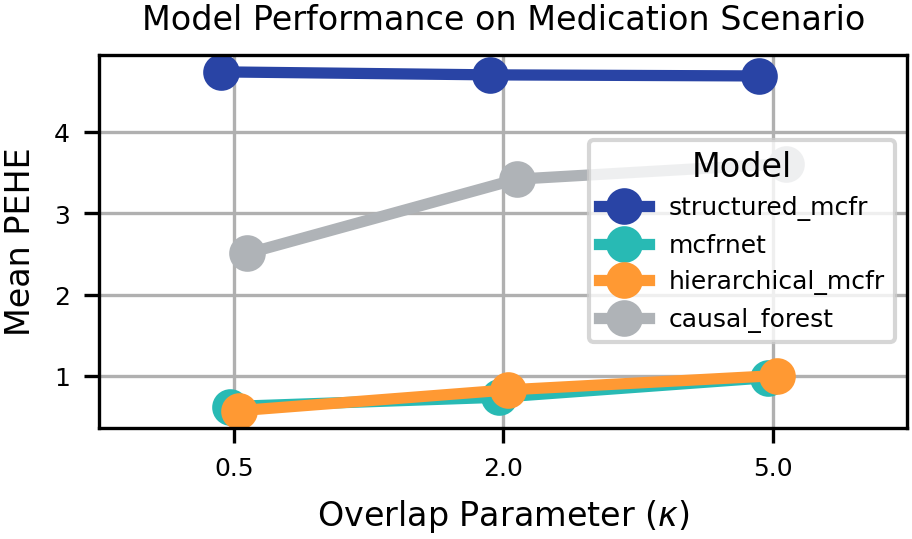

In [98]:
plot_medication_summary(df_all_models_run)

## 2. Overall Performance Summary Plot

In [100]:
exp_df = results_df[results_df["seed"]==69]
exp_df

,scenario,model,n_samples,kappa,seed,pehe_t1_vs_t0,pehe_t2_vs_t0,pehe_t3_vs_t0
184,education,hierarchical_mcfr,1000,0.5,69,1.142716,0.698671,0.391819
185,education,hierarchical_mcfr,1000,2.0,69,1.312596,1.343320,0.528710
186,education,hierarchical_mcfr,1000,5.0,69,1.413867,1.334905,0.546385
187,education,hierarchical_mcfr,3000,0.5,69,0.420226,0.419878,0.263182
188,education,hierarchical_mcfr,3000,2.0,69,0.779134,0.919601,0.310699
189,education,hierarchical_mcfr,3000,5.0,69,0.852683,1.275578,0.486702
190,education,hierarchical_mcfr,500,0.5,69,1.079883,0.651919,0.448275
191,education,hierarchical_mcfr,500,2.0,69,1.718507,2.147330,1.086464
192,education,hierarchical_mcfr,500,5.0,69,2.441057,1.764290,1.424119
193,education,mcfrnet,1000,0.5,69,1.245479,0.504931,0.344201


In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tueplots import bundles

def plot_pehe_vs_kappa(df):
    """
    Generates a faceted point plot of Mean PEHE vs. Kappa for all models,
    using a robust, non-LaTeX tueplots style.
    """
    if df is None or df.empty:
        print("DataFrame is empty. No results to plot.")
        return

    # Filter out any failed models for a cleaner plot
    df_plot = df[~df['model'].str.contains('structured')].copy()

    df_long = pd.melt(df_plot, 
                      id_vars=['scenario', 'model', 'kappa'],
                      value_vars=['pehe_t1_vs_t0', 'pehe_t2_vs_t0', 'pehe_t3_vs_t0'],
                      var_name='effect', value_name='pehe')
    df_long['effect'] = df_long['effect'].str.replace('pehe_', '').str.upper()

    # --- THE ROBUST FIX IS HERE ---
    # 1. Get the base style from the bundle
    neurips_style = bundles.neurips2024()
    # 2. Explicitly force the 'text.usetex' setting to False
    neurips_style['text.usetex'] = False

    # 3. Apply the modified style
    with plt.rc_context(neurips_style):
        g = sns.catplot(
            data=df_long,
            x='kappa',
            y='pehe',
            hue='model',
            col='effect',
            row='scenario',
            kind='point',
            dodge=True, 
            errorbar=('ci', 95),
            capsize=.1,
            height=3,
            aspect=1.3,
            sharey=False
        )

        g.fig.suptitle('Model Performance (PEHE) vs. Treatment Overlap (Kappa)', y=1.03)
        g.set_axis_labels('Overlap Parameter ($\\kappa$)', 'Mean PEHE (Lower is Better)')
        g.set_titles(row_template="{row_name} Scenario", col_template="{col_name}")
        g.despine(left=True)
        plt.tight_layout(rect=[0, 0, 1, 0.97])
        
        plt.savefig('summary_pehe_vs_kappa.pdf')
        print("Plot saved as 'summary_pehe_vs_kappa.pdf'")
        plt.show()

/usr/local/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Plot saved as 'summary_pehe_vs_kappa.pdf'


RuntimeError: latex was not able to process the following string:
b'lp'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmp0jklyafi 0375b9072ca7ffa4c3f246fda4b5cfe004b96886e8fa375e69a9b1eca3ec4ebc.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.24 (TeX Live 2022/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./0375b9072ca7ffa4c3f246fda4b5cfe004b96886e8fa375e69a9b1eca3ec4ebc.tex
LaTeX2e <2022-11-01> patch level 1
L3 programming layer <2023-01-16>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2022/07/02 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))

! LaTeX Error: File `type1cm.sty' not found.

Type X to quit or <RETURN> to proceed,
or enter new name. (Default extension: sty)

Enter file name: 
! Emergency stop.
<read *> 
         
l.8 \usepackage
               {type1ec}^^M
No pages of output.
Transcript written on tmp0jklyafi/0375b9072ca7ffa4c3f246fda4b5cfe004b96886e8fa3
75e69a9b1eca3ec4ebc.log.




<Figure size 3510x2700 with 9 Axes>

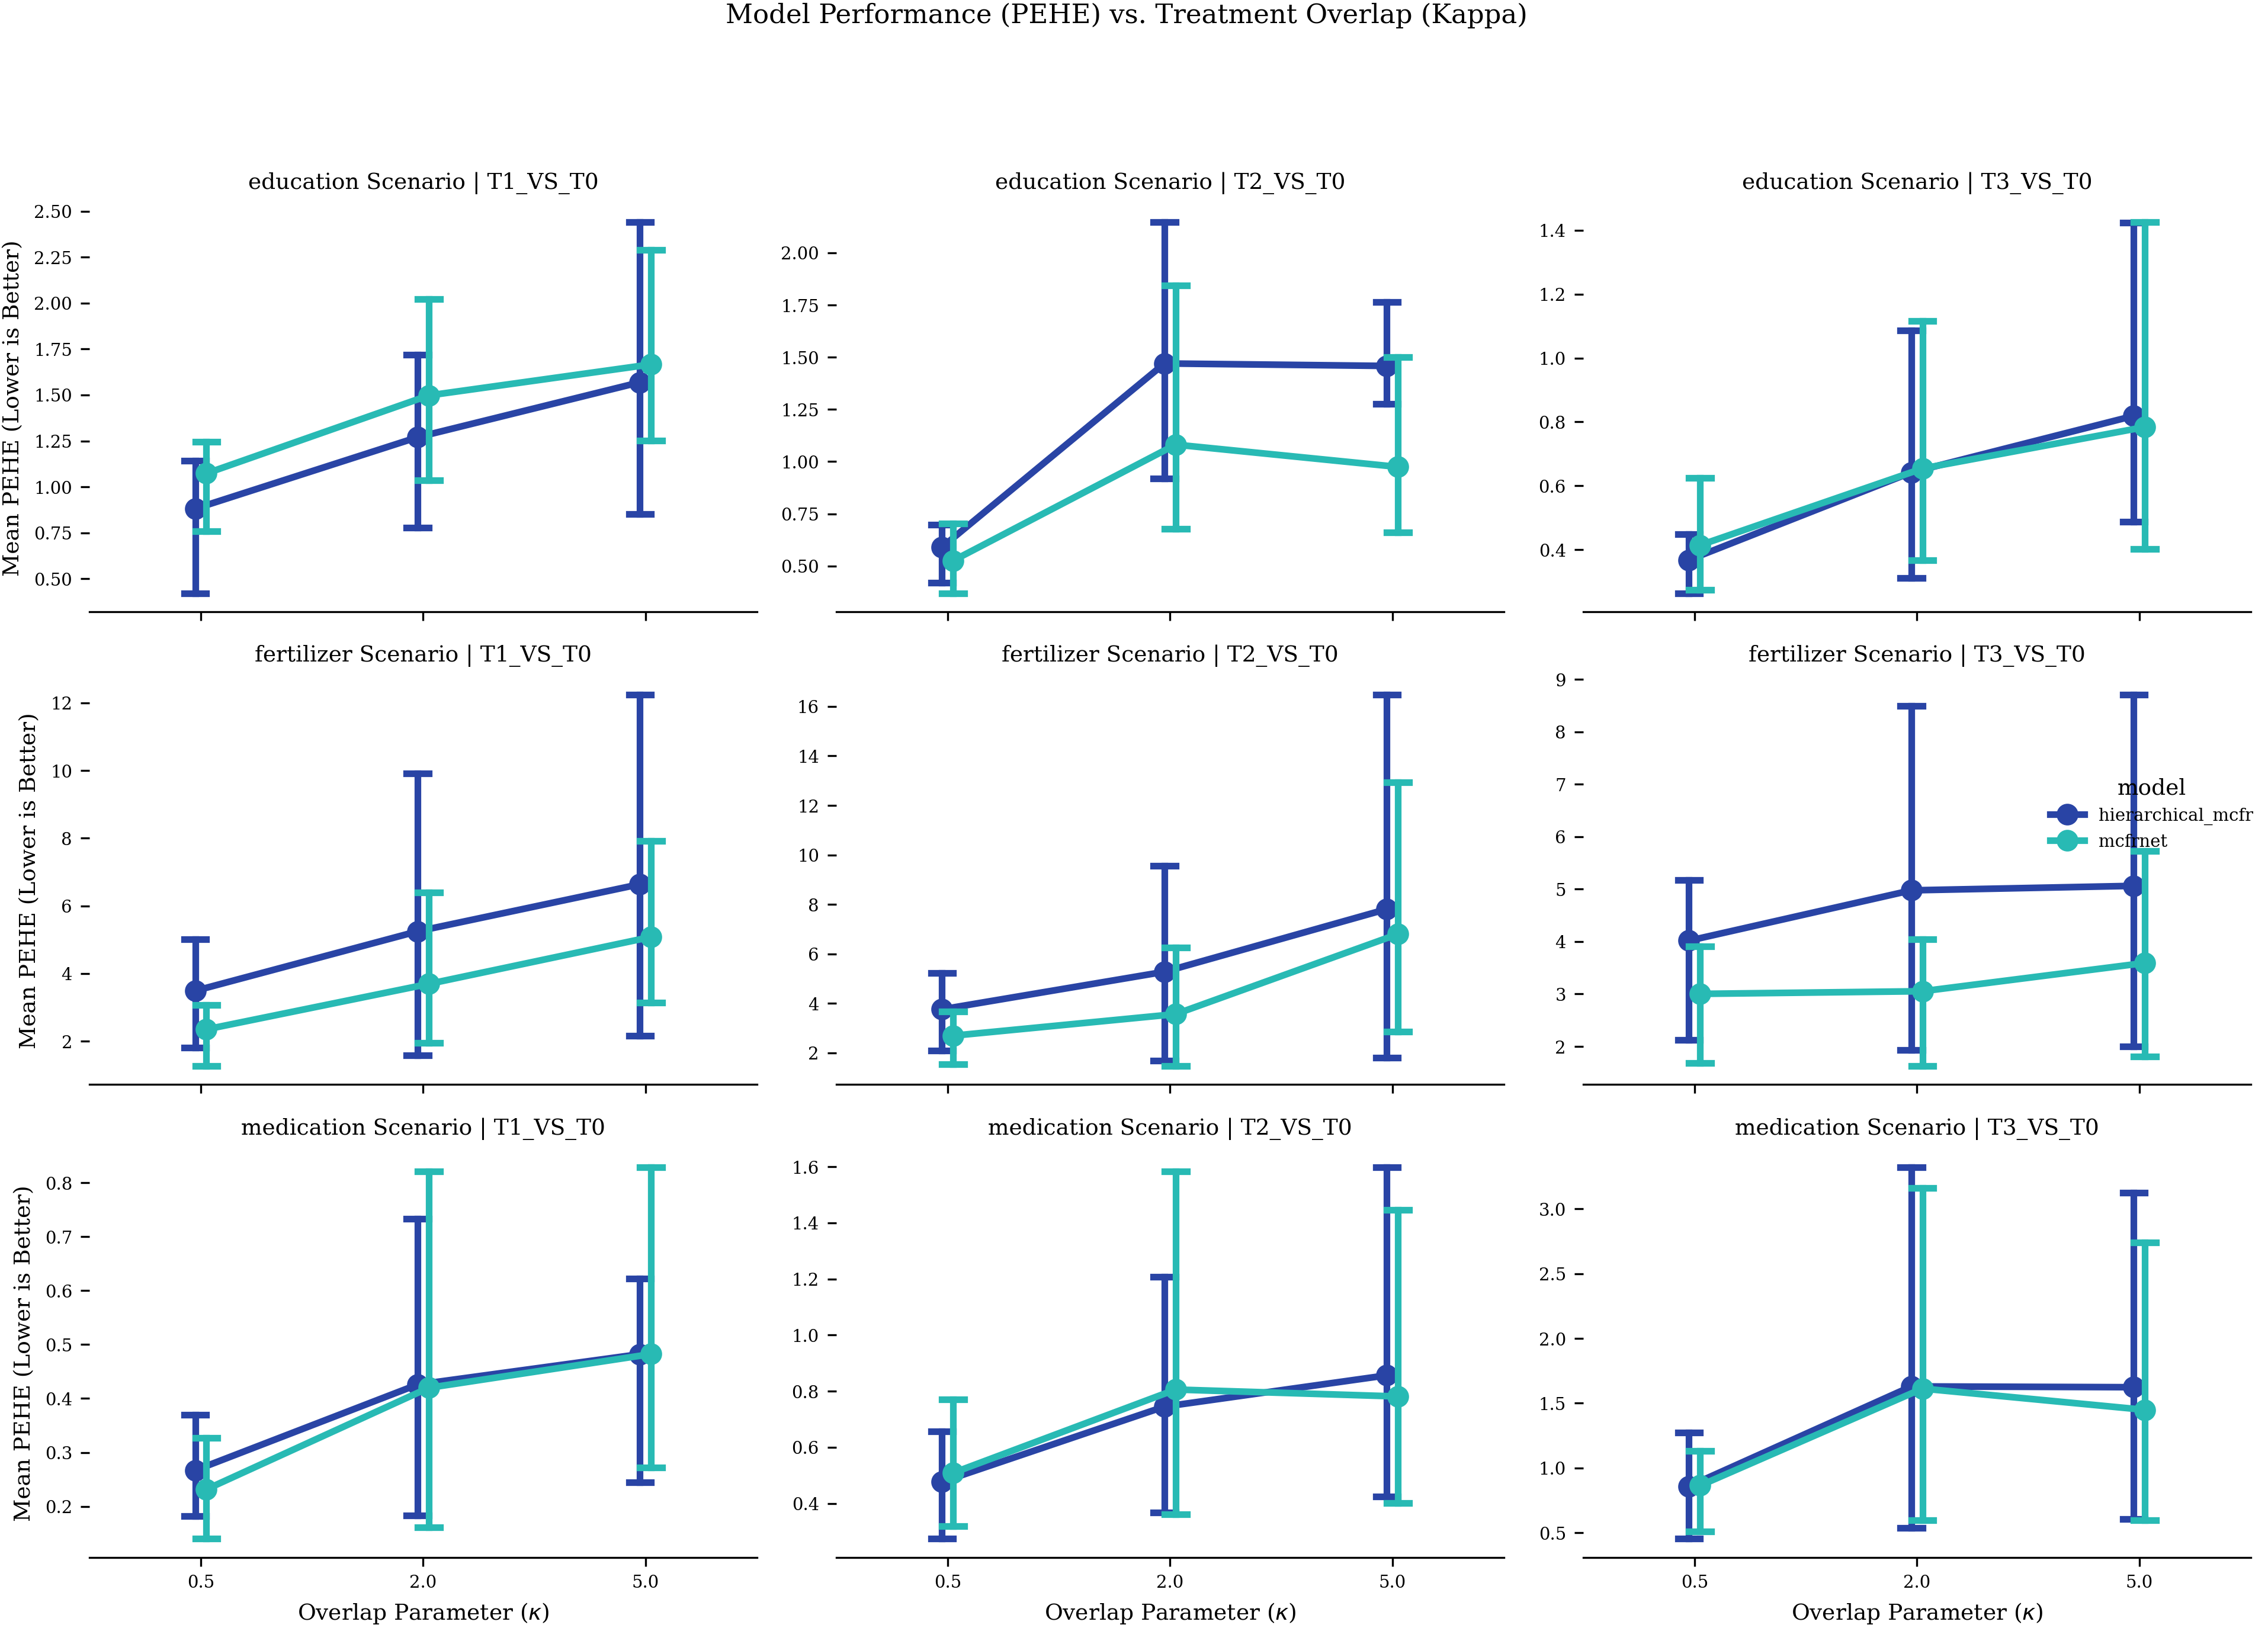

In [104]:
plot_pehe_vs_kappa(exp_df)

## 3. Deep Dive into a Single Experiment Run

The plots below are for analyzing a **single** run in more detail. You can change the `EXAMPLE_RUN_PATH` variable to point to any specific `cate_results.npz` file you want to investigate.

In [13]:
# --- Define the path to a specific experiment's results ---
# Change this path to visualize a different experiment run
EXAMPLE_RUN_PATH = "results/medication/hierarchical_mcfr/n5000_k2.0/seed1/cate_results.npz"

/tmp/ipykernel_22532/127244987.py:64: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.96])


Styled plot saved as 'cate_comparison_scatter_styled.pdf'


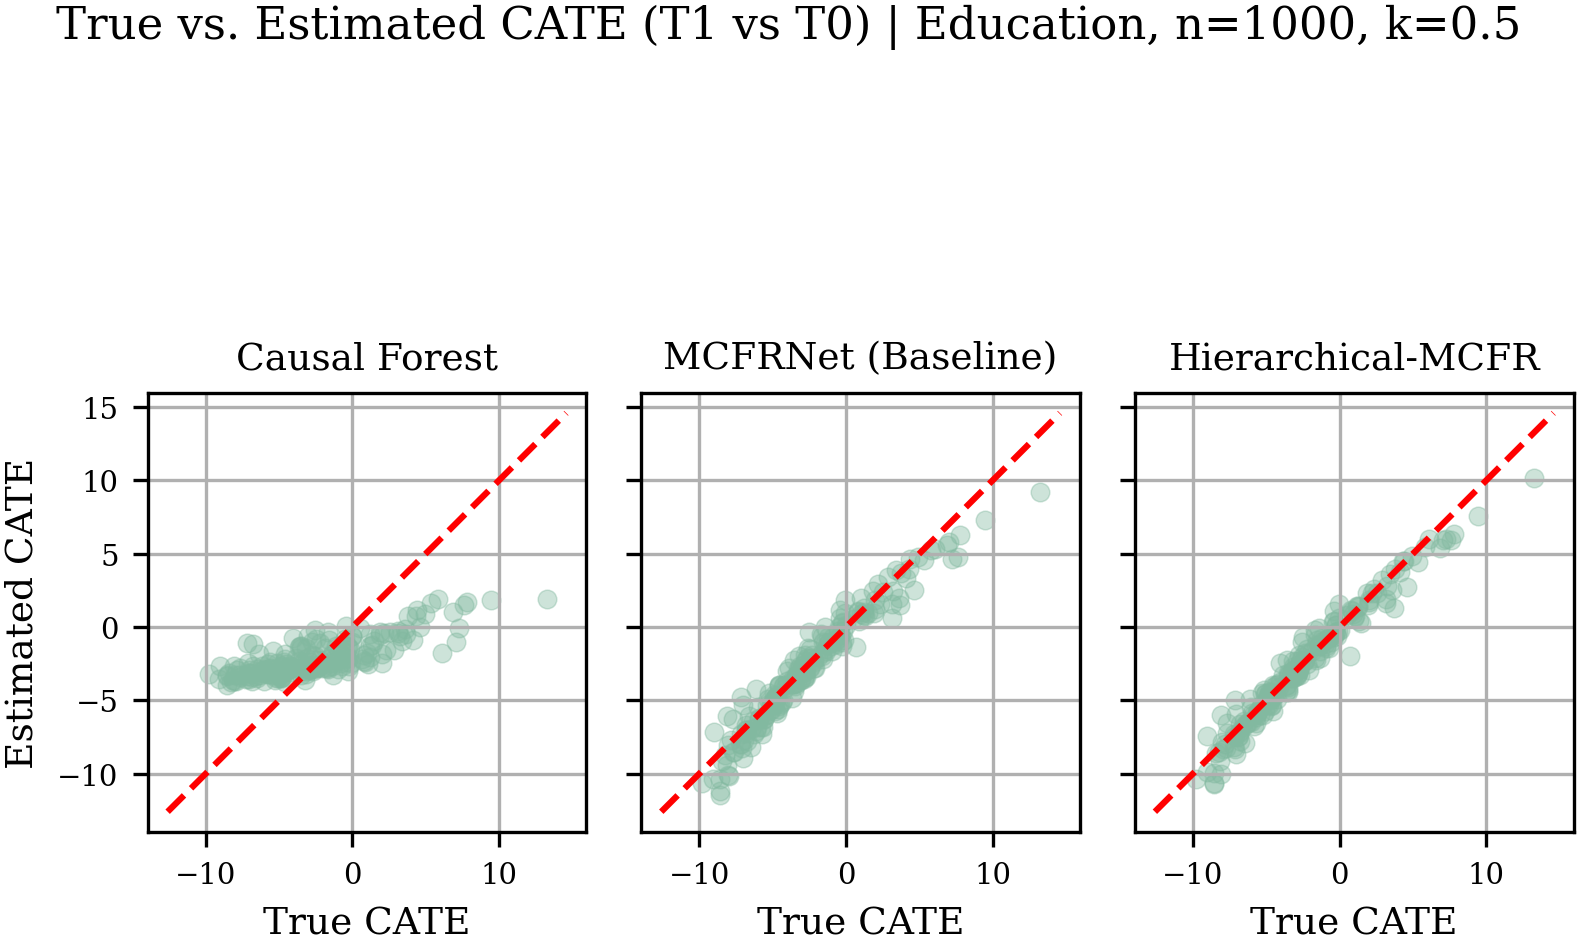

In [121]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tueplots import bundles

def plot_comparison_scatter(run_dir, scenario, n_samples, kappa, seed):
    """
    Generates a side-by-side comparison of True vs. Estimated CATE scatter plots.
    This version uses default tueplots sizing for robustness.
    """
    models_to_plot = ['causal_forest', 'mcfrnet', 'hierarchical_mcfr']
    model_names_pretty = ['Causal Forest', 'MCFRNet (Baseline)', 'Hierarchical-MCFR']
    
    results_data = {}
    
    for model in models_to_plot:
        path = os.path.join(run_dir, scenario, model, f"n{n_samples}_k{kappa}", f"seed{seed}", "cate_results.npz")
        try:
            results_data[model] = np.load(path)
        except FileNotFoundError:
            print(f"Warning: Results file not found for model '{model}' at {path}. Skipping.")
            
    if len(results_data) == 0:
        print("No valid results found for this condition.")
        return

    # --- Define styles ---
    plot_style = bundles.neurips2024()
    plot_style['text.usetex'] = False
    plot_color = rgb.tue_lightgreen

    with plt.rc_context(plot_style):
        # --- FIX: Let tueplots and matplotlib handle the size automatically ---
        # We removed all custom sizing logic.
        fig, axes = plt.subplots(1, len(results_data), sharex=True, sharey=True)
        fig.suptitle(f'True vs. Estimated CATE (T1 vs T0) | {scenario.title()}, n={n_samples}, k={kappa}', y=1.05)

        min_val, max_val = np.inf, -np.inf
        for model in results_data:
            min_val = min(min_val, results_data[model]['true_cate'][:, 0].min(), results_data[model]['est_cate'][:, 0].min())
            max_val = max(max_val, results_data[model]['true_cate'][:, 0].max(), results_data[model]['est_cate'][:, 0].max())
        
        min_val *= 1.1
        max_val *= 1.1

        for i, model in enumerate(results_data.keys()):
            ax = axes[i]
            data = results_data[model]
            true_cate_t1 = data['true_cate'][:, 0]
            est_cate_t1 = data['est_cate'][:, 0]

            ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=1.5)
            sns.scatterplot(x=true_cate_t1, y=est_cate_t1, alpha=0.4, s=20, ax=ax, edgecolor=None, color=plot_color)
            
            ax.set_title(model_names_pretty[i])
            ax.set_xlabel("True CATE")
            ax.set_aspect('equal', 'box')
            ax.grid(True)

        axes[0].set_ylabel("Estimated CATE")
        
        # Use a slightly larger bottom margin to prevent labels from overlapping title
        plt.tight_layout(rect=[0, 0.03, 1, 0.96])
        plt.savefig('cate_comparison_scatter_styled.pdf')
        print("Styled plot saved as 'cate_comparison_scatter_styled.pdf'")
        plt.show()
        
# --- Example of how to call the updated function ---
if __name__ == '__main__':
    # Define the path to the specific timestamped run folder
    RUN_FOLDER = "results/2025-09-16_20-29-36" # <-- Change this to your actual folder name
    
    # Choose a specific experimental run to visualize from within that folder
    plot_comparison_scatter(
        run_dir=RUN_FOLDER,
        scenario='education', 
        n_samples=1000, 
        kappa=0.5, 
        seed=70
    )

findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times



Generating True vs. Estimated CATE plot for: results/medication/hierarchical_mcfr/n5000_k2.0/seed1/cate_results.npz


findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


Plot saved as 'cate_scatter_plot.pdf'


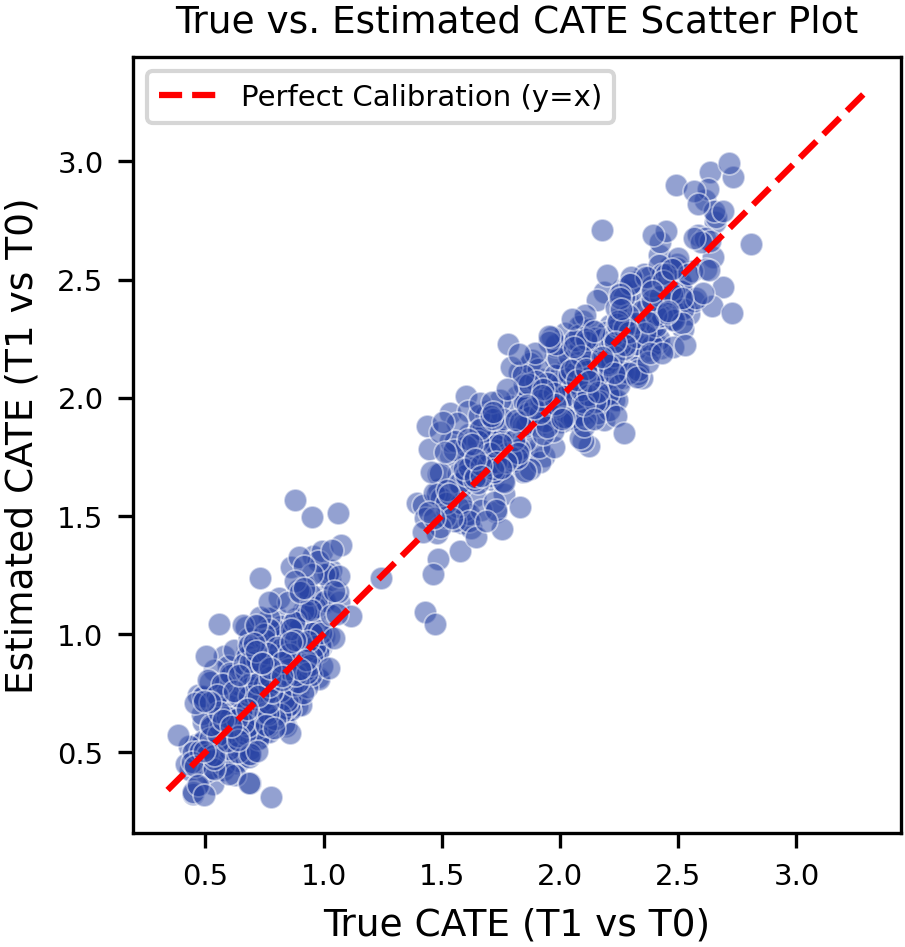

In [109]:
plot_true_vs_est_cate(EXAMPLE_RUN_PATH)

In [16]:
def plot_cate_vs_feature(results_path, feature_index=0, feature_name='Feature'):
    """
    Plots true and estimated CATE against a key feature to check for heterogeneity.
    """
    print(f"\nGenerating CATE vs. Feature plot for: {results_path}")
    try:
        data = np.load(results_path)
        est_cate, true_cate, X_test = data['est_cate'], data['true_cate'], data['X_test']
    except (FileNotFoundError, KeyError) as e:
        print(f"Error: Could not load required data from {results_path}. Did you save X_test? Error: {e}")
        return

    cate_t1_true, cate_t1_est = true_cate[:, 0], est_cate[:, 0]
    feature_values = X_test[:, feature_index]
    sample_indices = np.random.choice(len(feature_values), size=min(500, len(feature_values)), replace=False)

    with plt.rc_context(bundles.neurips2024(usetex=False)):
        fig, ax = plt.subplots()
        sns.regplot(x=feature_values[sample_indices], y=cate_t1_true[sample_indices], 
                    scatter_kws={'alpha':0.3, 's':20}, 
                    line_kws={'ls':'--'}, label='True CATE Trend', ax=ax)
        sns.regplot(x=feature_values[sample_indices], y=cate_t1_est[sample_indices], 
                    scatter_kws={'alpha':0.3, 's':20}, 
                    label='Estimated CATE Trend', ax=ax)
        
        ax.set_xlabel(f"{feature_name} (X_{feature_index+1})")
        ax.set_ylabel("CATE (T1 vs T0)")
        ax.set_title(f"CATE vs. {feature_name}")
        ax.legend()
        ax.grid(True)
        plt.tight_layout()
        plt.savefig('cate_vs_feature_plot.pdf')
        print("Plot saved as 'cate_vs_feature_plot.pdf'")
        plt.show()

In [17]:
# For the 'medication' scenario, feature 0 is 'Disease Severity'
plot_cate_vs_feature(EXAMPLE_RUN_PATH, feature_index=0, feature_name='Disease Severity')


Generating CATE vs. Feature plot for: results/medication/hierarchical_mcfr/n5000_k2.0/seed1/cate_results.npz
Error: Could not load required data from results/medication/hierarchical_mcfr/n5000_k2.0/seed1/cate_results.npz. Did you save X_test? Error: 'X_test is not a file in the archive'
